# Dropout
:label:`sec_dropout`


Let's think briefly about what we
expect from a good predictive model.
We want it to peform well on unseen data.
Classical generalization theory
suggests that to close the gap between
train and test performance,
we should aim for a simple model.
Simplicity can come in the form
of a small number of dimensions.
We explored this when discussing the
monomial basis functions of linear models
in :numref:`sec_generalization_basics`.
Additionally, as we saw when discussing weight decay
($\ell_2$ regularization) in :numref:`sec_weight_decay`,
the (inverse) norm of the parameters also
represents a useful measure of simplicity.
Another useful notion of simplicity is smoothness,
i.e., that the function should not be sensitive
to small changes to its inputs.
For instance, when we classify images,
we would expect that adding some random noise
to the pixels should be mostly harmless.

In 1995, Christopher Bishop formalized
this idea when he proved that training with input noise
is equivalent to Tikhonov regularization :cite:`Bishop.1995`.
This work drew a clear mathematical connection
between the requirement that a function be smooth (and thus simple),
and the requirement that it be resilient
to perturbations in the input.

Then, in 2014, :citet:`Srivastava.Hinton.Krizhevsky.ea.2014`
developed a clever idea for how to apply Bishop's idea
to the internal layers of a network, too.
Their idea, called *dropout*, involves
injecting noise while computing
each internal layer during forward propagation,
and it has become a standard technique
for training neural networks.
The method is called *dropout* because we literally
*drop out* some neurons during training.
Throughout training, on each iteration,
standard dropout consists of zeroing out
some fraction of the nodes in each layer
before calculating the subsequent layer.

To be clear, we are imposing
our own narrative with the link to Bishop.
The original paper on dropout
offers intuition through a surprising
analogy to sexual reproduction.
The authors argue that neural network overfitting
is characterized by a state in which
each layer relies on a specific
pattern of activations in the previous layer,
calling this condition *co-adaptation*.
dropout, they claim, breaks up co-adaptation
just as sexual reproduction is argued to
break up co-adapted genes.
While the explanatory of this theory is certainly up for debate,
the dropout technique itself has proved enduring,
and various forms of dropout are implemented
in most deep learning libraries. 


The key challenge is how to inject this noise.
One idea is to inject the noise in an *unbiased* manner
so that the expected value of each layer---while fixing
the others---equals to the value it would have taken absent noise.
In Bishop's work, he added Gaussian noise
to the inputs to a linear model.
At each training iteration, he added noise
sampled from a distribution with mean zero
$\epsilon \sim \mathcal{N}(0,\sigma^2)$ to the input $\mathbf{x}$,
yielding a perturbed point $\mathbf{x}' = \mathbf{x} + \epsilon$.
In expectation, $E[\mathbf{x}'] = \mathbf{x}$.

In standard dropout regularization,
one zeros out some fraction of the nodes in each layer
and then *debiases* each layer by normalizing
by the fraction of nodes that were retained (not dropped out).
In other words,
with *dropout probability* $p$,
each intermediate activation $h$ is replaced by
a random variable $h'$ as follows:

$$
\begin{aligned}
h' =
\begin{cases}
    0 & \text{ with probability } p \\
    \frac{h}{1-p} & \text{ otherwise}
\end{cases}
\end{aligned}
$$

By design, the expectation remains unchanged, i.e., $E[h'] = h$.


In [1]:
import Flux,Plots,Statistics

In [2]:
using Flux,Statistics
model = Chain(Dense(ones(3,2)), Dropout(0.4))

Chain(
  Dense(2 => 3),                        # 9 parameters
  Dropout(0.4),
) 

## Dropout in Practice

Recall the MLP with a hidden layer and 5 hidden units
in :numref:`fig_mlp`.
When we apply dropout to a hidden layer,
zeroing out each hidden unit with probability $p$,
the result can be viewed as a network
containing only a subset of the original neurons.
In :numref:`fig_dropout2`, $h_2$ and $h_5$ are removed.
Consequently, the calculation of the outputs
no longer depends on $h_2$ or $h_5$
and their respective gradient also vanishes
when performing backpropagation.
In this way, the calculation of the output layer
cannot be overly dependent on any
one element of $h_1, \ldots, h_5$.

![MLP before and after dropout.](../img/dropout2.svg)
:label:`fig_dropout2`

Typically, we disable dropout at test time.
Given a trained model and a new example,
we do not drop out any nodes
and thus do not need to normalize.
However, there are some exceptions:
some researchers use dropout at test time as a heuristic
for estimating the *uncertainty* of neural network predictions:
if the predictions agree across many different dropout masks,
then we might say that the network is more confident.

## Implementation from Scratch

To implement the dropout function for a single layer,
we must draw as many samples
from a Bernoulli (binary) random variable
as our layer has dimensions,
where the random variable takes value $1$ (keep)
with probability $1-p$ and $0$ (drop) with probability $p$.
One easy way to implement this is to first draw samples
from the uniform distribution $U[0, 1]$.
Then we can keep those nodes for which the corresponding
sample is greater than $p$, dropping the rest.

In the following code, we (**implement a `dropout_layer` function
that drops out the elements in the tensor input `X`
with probability `dropout`**),
rescaling the remainder as described above:
dividing the survivors by `1.0-dropout`.


In [3]:
# Dropout does not have effect in the test mode
model(ones(2, 7))  

3×7 Matrix{Float64}:
 2.0  2.0  2.0  2.0  2.0  2.0  2.0
 2.0  2.0  2.0  2.0  2.0  2.0  2.0
 2.0  2.0  2.0  2.0  2.0  2.0  2.0

Dropout does not have effect in the test mode, but after training we can see that some nodes are 0.


In [4]:
Flux.trainmode!(model);  
model(ones(2, 7))

3×7 Matrix{Float64}:
 0.0      0.0      0.0      3.33333  3.33333  3.33333  0.0
 0.0      0.0      3.33333  3.33333  3.33333  0.0      3.33333
 3.33333  3.33333  3.33333  3.33333  0.0      3.33333  0.0

In [5]:
y = model(ones(2, 10_000));

In [6]:
using Statistics
# The dropout does not make a big change on the mean
print(mean(y))  


1.99811111111111

### Using dropout in the previous MNIST problem 

### Defining the Model

The model below applies dropout to the output
of each hidden layer (following the activation function).
We can set dropout probabilities for each layer separately.
A common trend is to set
a lower dropout probability closer to the input layer.
We ensure that dropout is only active during training.


In [7]:
using Flux
model = Chain(
  Dense(28*28,200, relu),Dropout(0.5),
  Dense(200,200,relu),Dropout(0.5),
  Dense(200, 10),
  softmax)

Chain(
  Dense(784 => 200, relu),              # 157_000 parameters
  Dropout(0.5),
  Dense(200 => 200, relu),              # 40_200 parameters
  Dropout(0.5),
  Dense(200 => 10),                     # 2_010 parameters
  NNlib.softmax,
)                   # Total: 6 arrays, 199_210 parameters, 778.602 KiB.

In [8]:
using MLDatasets

# load training set
train_x, train_y = MNIST.traindata();

# load test set
test_x,  test_y  = MNIST.testdata();

┌ Warning: MNIST.traindata() is deprecated, use `MNIST(split=:train)[:]` instead.
└ @ MLDatasets C:\Users\Szasz\.julia\packages\MLDatasets\bg0uc\src\datasets\vision\mnist.jl:187
┌ Warning: MNIST.testdata() is deprecated, use `MNIST(split=:test)[:]` instead.
└ @ MLDatasets C:\Users\Szasz\.julia\packages\MLDatasets\bg0uc\src\datasets\vision\mnist.jl:195


In [9]:
x_train = Float32.(train_x)
y_train = Flux.onehotbatch(train_y, 0:9);

x_test = Float32.(test_x)
y_test = Flux.onehotbatch(test_y, 0:9);

loss(X, y) = Flux.crossentropy(model(X), y)
opt = Flux.ADAM();

### [**Training**]

The following is similar to the training of MLPs described previously.


In [10]:
using Statistics

function calculate_accuracy_test()
    test_data = [(Flux.flatten(x_test), test_y)]
    accuracy = 0
    err=0;
    nr_of_errors=0
    for i in 1:length(test_y)
        if findmax(model(test_data[1][1][:, i]))[2] - 1  == test_y[i]
            accuracy = accuracy + 1
        else
            nr_of_errors=nr_of_errors+1
            A=abs.(model(test_data[1][1][:, i]) .- y_test[:,i])
            aux=0
            for a in A
                aux=aux+a
            end
            err=err+aux;
        end
    end
    
    m = accuracy / length(test_y)
    n = err/ length(test_y)
    s = nr_of_errors 
    println("The val_accuracy is: ",m)
    println("Mean absolute error (TEST): ",n)
    println("Number of errors: ",s)
    return m,n,s
end;

In [11]:
#with this function we'll calculate the accuracy in every epoch
using Statistics

function calculate_accuracy_train()
    train_data = [(Flux.flatten(x_train), train_y)]
    err=0;
    for i in 1:length(train_y)
        if findmax(model(train_data[1][1][:, i]))[2] - 1  != train_y[i]
            A=abs.(model(train_data[1][1][:, i]) .- y_train[:,i])
            aux=0
            for a in A
                aux=aux+a
            end
            err=err+aux;
        end
    end    
    n = err/ length(train_y)
    println("Mean absolute error (TRAIN): ",n)
    return n
end;

In [12]:
using Flux

parameters = Flux.params(model)
# flatten() function converts array 28x28x60000 into 784x60000 
train_data = [(Flux.flatten(x_train), Flux.flatten(y_train))]

val_acc=zeros(0)
mean_err_test=zeros(0)
nr_err=zeros(0)
mean_err_train=zeros(0)
nr_of_epoch=8

for i in 1:nr_of_epoch
    println("epoch ",i)
    Flux.train!(loss, parameters, train_data, opt)
    
    n = calculate_accuracy_train()
    append!(mean_err_train,n)
    m, n, s = calculate_accuracy_test()
    append!( val_acc, m )
    append!( mean_err_test, n )
    append!( nr_err, s )
    
end

epoch 1
Mean absolute error (TRAIN): 1.4040046
The val_accuracy is: 0.2259
Mean absolute error (TEST): 1.3896588
Number of errors: 7741
epoch 2
Mean absolute error (TRAIN): 1.0660497
The val_accuracy is: 0.413
Mean absolute error (TEST): 1.0462993
Number of errors: 5870
epoch 3
Mean absolute error (TRAIN): 0.7766581
The val_accuracy is: 0.5655
Mean absolute error (TEST): 0.7701285
Number of errors: 4345
epoch 4
Mean absolute error (TRAIN): 0.6594505
The val_accuracy is: 0.6283
Mean absolute error (TEST): 0.65415174
Number of errors: 3717
epoch 5
Mean absolute error (TRAIN): 0.59138894
The val_accuracy is: 0.6658
Mean absolute error (TEST): 0.58365583
Number of errors: 3342
epoch 6
Mean absolute error (TRAIN): 0.5424026
The val_accuracy is: 0.6955
Mean absolute error (TEST): 0.52774143
Number of errors: 3045
epoch 7
Mean absolute error (TRAIN): 0.49865982
The val_accuracy is: 0.7178
Mean absolute error (TEST): 0.4850984
Number of errors: 2822
epoch 8
Mean absolute error (TRAIN): 0.45803

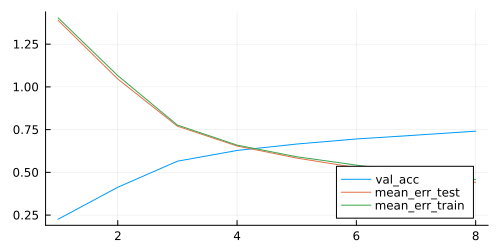

In [13]:
x = range(1, nr_of_epoch, step=1)

p= Plots.plot(x,val_acc,label="val_acc",legend=:bottomright, size=(500, 250))
p= Plots.plot!(p,x,mean_err_test,label="mean_err_test")
p= Plots.plot!(p,x,mean_err_train,label="mean_err_train")

## Summary

Beyond controlling the number of dimensions and the size of the weight vector, dropout is yet another tool to avoid overfitting. Often they are used jointly.
Note that dropout is
used only during training:
it replaces an activation $h$ with a random variable with expected value $h$.


## Exercises

1. What happens if you change the dropout probabilities for the first and second layers? In particular, what happens if you switch the ones for both layers? Design an experiment to answer these questions, describe your results quantitatively, and summarize the qualitative takeaways.
1. Increase the number of epochs and compare the results obtained when using dropout with those when not using it.
1. What is the variance of the activations in each hidden layer when dropout is and is not applied? Draw a plot to show how this quantity evolves over time for both models.
1. Why is dropout not typically used at test time?
1. Using the model in this section as an example, compare the effects of using dropout and weight decay. What happens when dropout and weight decay are used at the same time? Are the results additive? Are there diminished returns (or worse)? Do they cancel each other out?
1. What happens if we apply dropout to the individual weights of the weight matrix rather than the activations?
1. Invent another technique for injecting random noise at each layer that is different from the standard dropout technique. Can you develop a method that outperforms dropout on the Fashion-MNIST dataset (for a fixed architecture)?
